# Menjalankan QA Tanpa Intermediate Task - Transfer Learning

# Import semua module

In [1]:
#!pip install datasets
#!pip install transformers
#!pip install tensorboard
#!pip install evaluate
#!pip install git+https://github.com/IndoNLP/nusa-crowd.git@release_exp

In [2]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ['TRANSFORMERS_NO_ADVISORY_WARNINGS'] = 'true'

In [3]:
!pip install -r requirements.txt

  Cloning https://github.com/IndoNLP/nusa-crowd.git (to revision 7748513d20331e72f9969f94f5d43c7f2d4a59a5) to /tmp/pip-install-pbxwdf8v/nusacrowd_c262c46d505a4f1fa9ccc193353cf349
  Running command git clone --filter=blob:none -q https://github.com/IndoNLP/nusa-crowd.git /tmp/pip-install-pbxwdf8v/nusacrowd_c262c46d505a4f1fa9ccc193353cf349
  Running command git rev-parse -q --verify 'sha^7748513d20331e72f9969f94f5d43c7f2d4a59a5'
  Running command git fetch -q https://github.com/IndoNLP/nusa-crowd.git 7748513d20331e72f9969f94f5d43c7f2d4a59a5
  Running command git checkout -q 7748513d20331e72f9969f94f5d43c7f2d4a59a5
  Resolved https://github.com/IndoNLP/nusa-crowd.git to commit 7748513d20331e72f9969f94f5d43c7f2d4a59a5
  Preparing metadata (setup.py) ... done
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [4]:
# Melihat GPU yang tersedia dan penggunaannya.
!nvidia-smi

Tue Mar 21 13:20:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.126.02   Driver Version: 418.126.02   CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:06:00.0 Off |                    0 |
| N/A   35C    P0    56W / 300W |   7618MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   36C    P0    55W / 300W |   3825MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [5]:
# Memilih GPU yang akan digunakan (contohnya: GPU #7)
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6'

In [6]:
import transformers
import evaluate
import torch
import operator
import ast
import json
import re
import sys
import contextlib

import numpy as np
import pandas as pd
import torch.nn as nn

from multiprocessing import cpu_count
from evaluate import load
from nusacrowd import NusantaraConfigHelper
from torch.utils.data import DataLoader
from datetime import datetime
from huggingface_hub import notebook_login
from tqdm import tqdm

from datasets import (
    load_dataset, 
    load_from_disk,
    Dataset,
    DatasetDict
)
from transformers import (
    BigBirdTokenizerFast,
    BigBirdForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    BertForSequenceClassification,
    BertForQuestionAnswering,
    AutoModel, 
    BertTokenizerFast,
    AutoTokenizer, 
    AutoModel, 
    BertTokenizer, 
    BertForPreTraining,
    AutoModelForSequenceClassification,
    AutoModelForQuestionAnswering,
    EvalPrediction,
    AutoModel,
    BertModel
)

# Definisikan hyperparameter

In [7]:
#MODEL_NAME = "indolem/indobert-base-uncased"
#MODEL_NAME = "afaji/fine-tuned-IndoNLI-Translated-with-indobert-base-uncased"
MODEL_NAME = "afaji/fine-tuned-DatasetQAS-TYDI-QA-ID-with-indobert-base-uncased-with-ITTL-without-freeze-LR-1e-05"
#MODEL_NAME = "indobenchmark/indobert-large-p2"
SEED = 42
EPOCH = 1
BATCH_SIZE = 16
GRADIENT_ACCUMULATION = 4
LEARNING_RATE = 1e-5
MAX_LENGTH = 400
STRIDE = 100
LOGGING_STEPS = 50
WARMUP_RATIO = 0.06
WEIGHT_DECAY = 0.01
MAXIMUM_SEARCH_ITER =  2
# Untuk mempercepat training, saya ubah SAMPLE menjadi 100.
# Bila mau menggunakan keseluruhan data, gunakan: 
SAMPLE = sys.maxsize
# SAMPLE = 10

# Import dataset QAS

In [8]:
!pip install git+https://github.com/IndoNLP/nusa-crowd.git

  Cloning https://github.com/IndoNLP/nusa-crowd.git to /tmp/pip-req-build-hjd79d8u
  Running command git clone --filter=blob:none -q https://github.com/IndoNLP/nusa-crowd.git /tmp/pip-req-build-hjd79d8u
  Resolved https://github.com/IndoNLP/nusa-crowd.git to commit 3b16ae803907ce70eb186c2da7868c25bbdd8539
  Preparing metadata (setup.py) ... done
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Definisikan tokenizer

In [10]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Definisikan fungsi pre-processnya

In [11]:
conhelps = NusantaraConfigHelper()
data_qas_id = conhelps.filtered(lambda x: 'tydiqa_id' in x.dataset_name)[0].load_dataset()

df_train = pd.DataFrame(data_qas_id['train'])
df_validation = pd.DataFrame(data_qas_id['validation'])

cols = ['context', 'question', 'answer']
new_df_train = pd.DataFrame(columns=cols)

for i in range(len(df_train['context'])):
    answer_start = df_train['context'][i].index(df_train['label'][i])
    answer_end = answer_start + len(df_train['label'][i])
    new_df_train = new_df_train.append({'context': df_train["context"][i], 
                                        'question': df_train["question"][i], 
                                        'answer': {"text": df_train["label"][i], 
                                                   "answer_start": answer_start, 
                                                   "answer_end": answer_end}}, 
                                                   ignore_index=True)

cols = ['context', 'question', 'answer']
new_df_val = pd.DataFrame(columns=cols)    

for i in range(len(df_validation['context'])):
    answer_start = df_validation['context'][i].index(df_validation['label'][i])
    answer_end = answer_start + len(df_validation['label'][i])
    new_df_val = new_df_val.append({'context': df_validation["context"][i], 
                                    'question': df_validation["question"][i], 
                                    'answer': {"text": df_validation["label"][i], 
                                               "answer_start": answer_start, 
                                               "answer_end": answer_end}}, 
                                               ignore_index=True)    

train_dataset = Dataset.from_dict(new_df_train)
validation_dataset = Dataset.from_dict(new_df_val)

data_qas_id = DatasetDict({"train": train_dataset, "validation": validation_dataset})

  0%|          | 0/3 [00:00<?, ?it/s]

In [12]:
def rindex(lst, value, operator=operator):
      return len(lst) - operator.indexOf(reversed(lst), value) - 1

def preprocess_function_qa(examples, tokenizer, MAX_LENGTH=MAX_LENGTH, STRIDE=STRIDE, rindex=rindex, operator=operator):
    examples["question"] = [q.lstrip() for q in examples["question"]]
    examples["context"] = [c.lstrip() for c in examples["context"]]

    tokenized_examples = tokenizer(
      examples['question'],
      examples['context'],
      truncation=True,
      max_length = MAX_LENGTH,
      stride=STRIDE,
      return_overflowing_tokens=True,
      return_offsets_mapping=True,
      padding="max_length",
      return_tensors='np'
    )

    tokenized_examples['start_positions'] = []
    tokenized_examples['end_positions'] = []

    for seq_idx in range(len(tokenized_examples['input_ids'])):
        seq_ids = tokenized_examples.sequence_ids(seq_idx)
        offset_mappings = tokenized_examples['offset_mapping'][seq_idx]

        cur_example_idx = tokenized_examples['overflow_to_sample_mapping'][seq_idx]

        #answer = examples['answer'][seq_idx][0]
        answer = examples['answer'][cur_example_idx]
        answer = eval(str(answer))
        #answer_text = answer['text'][0]
        answer_start = answer['answer_start']
        #answer_end = answer_start + len(answer_text)
        answer_end = answer['answer_end']

        context_pos_start = seq_ids.index(1)
        context_pos_end = rindex(seq_ids, 1, operator)

        s = e = 0
        if (offset_mappings[context_pos_start][0] <= answer_start and
            offset_mappings[context_pos_end][1] >= answer_end):
          i = context_pos_start
          while offset_mappings[i][0] < answer_start:
            i += 1
          if offset_mappings[i][0] == answer_start:
            s = i
          else:
            s = i - 1

          j = context_pos_end
          while offset_mappings[j][1] > answer_end:
            j -= 1      
          if offset_mappings[j][1] == answer_end:
            e = j
          else:
            e = j + 1

        tokenized_examples['start_positions'].append(s)
        tokenized_examples['end_positions'].append(e)
    return tokenized_examples

# Mulai tokenisasi dan pre-process

In [13]:
tokenized_data_qas_id = data_qas_id.map(
    preprocess_function_qa,
    batched=True,
    remove_columns=data_qas_id['train'].column_names,
    num_proc=1,
    fn_kwargs={'tokenizer': tokenizer, 'MAX_LENGTH': MAX_LENGTH, 'STRIDE': STRIDE, 'rindex': rindex, 'operator': operator}
)

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [14]:
tokenized_data_qas_id = tokenized_data_qas_id.remove_columns(["offset_mapping", 
                                            "overflow_to_sample_mapping"])

In [15]:
tokenized_data_qas_id.set_format("torch", columns=["input_ids", "token_type_ids"], output_all_columns=True)

In [16]:
tokenized_data_qas_id_train = Dataset.from_dict(tokenized_data_qas_id["train"][:SAMPLE])
tokenized_data_qas_id_validation = Dataset.from_dict(tokenized_data_qas_id["validation"][:SAMPLE])

# Mendefinisikan argumen (dataops) untuk training nanti

In [17]:
TIME_NOW = str(datetime.now()).replace(":", "-").replace(" ", "_").replace(".", "_")
QA = './results/alur2-idk-mrc'
CHECKPOINT_DIR = f'{QA}-{TIME_NOW}/checkpoint/'
MODEL_DIR = f'{QA}-{TIME_NOW}/model/'
OUTPUT_DIR = f'{QA}-{TIME_NOW}/output/'
ACCURACY_DIR = f'{QA}-{TIME_NOW}/accuracy/'

# Mendefinisikan Training Arguments untuk train

In [18]:
training_args_qa = TrainingArguments(
    
    # Checkpoint
    output_dir=CHECKPOINT_DIR,
    save_strategy='epoch',
    save_total_limit=EPOCH,
    
    # Log
    report_to='tensorboard',
    logging_strategy='steps',
    logging_first_step=True,
    logging_steps=LOGGING_STEPS,
    
    # Train
    num_train_epochs=EPOCH,
    weight_decay=WEIGHT_DECAY,
    per_device_train_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION,
    learning_rate=LEARNING_RATE,
    warmup_ratio=WARMUP_RATIO,
    bf16=False,
    dataloader_num_workers=cpu_count(),
    
    # Miscellaneous
    evaluation_strategy='epoch',
    seed=SEED,
)

# Pendefinisian model Question Answering

In [19]:
model_qa = BertForQuestionAnswering.from_pretrained(MODEL_NAME)

In [20]:
model_qa = model_qa.to(device)

# Melakukan pengumpulan data dengan padding

In [21]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Mulai training untuk fine-tune SQUAD diatas IndoBERT

In [22]:
import string
import collections

# # Melakukan evaluasi dari prediksi
def normalize_text(s):
    def remove_articles(text):
        regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
        return re.sub(regex, " ", text)
    def white_space_fix(text):
        return " ".join(text.split())
    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)
    def lower(text):
        return text.lower()
    return white_space_fix(remove_articles(remove_punc(lower(s))))

def compute_f1_prec_rec(pred, gold):
    pred_tokens = normalize_text(pred).split() # True positive + False positive = Untuk precision
    gold_tokens = normalize_text(gold).split() # True positive + False negatives = Untuk recall
    common = collections.Counter(pred_tokens) & collections.Counter(gold_tokens)
    num_same = sum(common.values()) # True positive

    if len(gold_tokens) == 0 or len(pred_tokens) == 0: 
        return int(gold_tokens == pred_tokens)

    if num_same == 0:
        return 0

    precision = 1.0 * num_same / len(pred_tokens)
    recall = 1.0 * num_same / len(gold_tokens)
    f1 = (2.0 * precision * recall) / (precision + recall)

    return f1

def compute_metrics(predict_result):
    predictions_idx = np.argmax(predict_result.predictions, axis=2)
    denominator = len(predictions_idx[0])
    label_array = np.asarray(predict_result.label_ids)
    total_correct = 0
    f1_array = []
    precision_array = []
    recall_array = []

    for i in range(len(predict_result.predictions[0])):
        start_pred_idx = predictions_idx[0][i]
        end_pred_idx = predictions_idx[1][i] + 1
        start_gold_idx = label_array[0][i]
        end_gold_idx = label_array[1][i] + 1

        pred_text = tokenizer.decode(tokenized_data_qas_id_validation[i]['input_ids']
                                    [start_pred_idx: end_pred_idx])
        gold_text = tokenizer.decode(tokenized_data_qas_id_validation[i]['input_ids']
                                    [start_gold_idx: end_gold_idx])

        if pred_text == gold_text:
            total_correct += 1

        f1 = compute_f1_prec_rec(pred=pred_text, gold=gold_text)

        f1_array.append(f1)

    exact_match = ((total_correct / denominator) * 100.0)
    final_f1 = np.mean(f1_array) * 100.0

    return {'exact_match': exact_match, 'f1': final_f1}

In [23]:
trainer_qa = Trainer(
    model=model_qa,
    args=training_args_qa,
    #train_dataset=tokenized_data_qas_id_train,
    #eval_dataset=tokenized_data_qas_id_validation,
    tokenizer=tokenizer,
    #data_collator=data_collator,
    #compute_metrics=compute_metrics,
)

In [24]:
#trainer_qa.train()

# Menyimpan model Question Answering

In [25]:
trainer_qa.save_model(MODEL_DIR)

Saving model checkpoint to ./results/alur2-idk-mrc-2023-03-21_13-21-12_494250/model/
Configuration saved in ./results/alur2-idk-mrc-2023-03-21_13-21-12_494250/model/config.json
Model weights saved in ./results/alur2-idk-mrc-2023-03-21_13-21-12_494250/model/pytorch_model.bin
tokenizer config file saved in ./results/alur2-idk-mrc-2023-03-21_13-21-12_494250/model/tokenizer_config.json
Special tokens file saved in ./results/alur2-idk-mrc-2023-03-21_13-21-12_494250/model/special_tokens_map.json


# Melakukan prediksi dari model

In [26]:
predict_result = trainer_qa.predict(tokenized_data_qas_id_validation)
predict_result

***** Running Prediction *****
  Num examples = 573
  Batch size = 8


PredictionOutput(predictions=(array([[-8.35171  , -8.076599 , -8.503144 , ..., -9.282154 , -8.230426 ,
        -8.230472 ],
       [-8.80134  , -7.8416014, -8.878554 , ..., -8.203245 , -8.023994 ,
        -7.955187 ],
       [-8.406947 , -7.879238 , -7.557513 , ..., -8.06922  , -8.540085 ,
        -8.5421095],
       ...,
       [-8.366326 , -7.5886264, -7.8696113, ..., -9.025943 , -8.910945 ,
        -8.83718  ],
       [-7.4733953, -8.00692  , -8.180969 , ..., -8.620614 , -8.630537 ,
        -8.637637 ],
       [-8.517115 , -7.361902 , -8.58764  , ..., -9.03526  , -9.0543165,
        -9.013267 ]], dtype=float32), array([[-8.092257 , -8.07077  , -8.353189 , ..., -8.548285 , -7.2124186,
        -7.2126346],
       [-8.535385 , -8.4017315, -8.309286 , ..., -7.9303427, -7.9003634,
        -7.8861685],
       [-7.968836 , -7.887048 , -7.94197  , ..., -7.099453 , -8.311145 ,
        -8.295949 ],
       ...,
       [-8.2838   , -7.889635 , -8.5557995, ..., -8.739616 , -8.661087 ,
        -8

In [27]:
os.makedirs(os.path.dirname(OUTPUT_DIR), exist_ok=True)
with open(f'{OUTPUT_DIR}/output.txt', "w") as f:
  f.write(str(predict_result))
  f.close()

# Melakukan evaluasi dari prediksi

In [28]:
metric_result_before_filtering = compute_metrics(predict_result)
metric_result_before_filtering

{'exact_match': 62.129144851657934, 'f1': 76.50970983610755}

In [29]:
os.makedirs(os.path.dirname(ACCURACY_DIR), exist_ok=True)
with open(f'{ACCURACY_DIR}/accuracy.txt', "w") as f:
  f.write(str(metric_result_before_filtering))
  f.close()

# Coba Alur 3

In [68]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/n

True

In [60]:
!pip install svgling

import svgling
import nltk

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [74]:
from tqdm import tqdm

def create_qas_dataframe(predict_result):
    predictions_idx = np.argmax(predict_result.predictions, axis=2)
    question_decoded = []
    context_decoded = []
    answer_decoded = []
    
    for i in tqdm(range(len(predict_result.predictions[0]))):
        start_pred_idx = predictions_idx[0][i]
        end_pred_idx = predictions_idx[1][i] + 1
        pred_answer = tokenizer.decode(tokenized_data_qas_id_validation[i]['input_ids']
                                       [start_pred_idx: end_pred_idx], skip_special_tokens=True)
        answer_decoded.append(pred_answer)
        
        question = []
        context = []
         
        for j in range(len(tokenized_data_qas_id_validation[i]['token_type_ids'])):
            if tokenized_data_qas_id_validation[i]['token_type_ids'][j] == 0:
                question.append(tokenized_data_qas_id_validation[i]['input_ids'][j])
            else:
                context.append(tokenized_data_qas_id_validation[i]['input_ids'][j])

        question_decoded.append(tokenizer.decode(question, skip_special_tokens=True))
        context_decoded.append(tokenizer.decode(context, skip_special_tokens=True))
    
    qas_df = pd.DataFrame({'Context': context_decoded, 
                           'Question': question_decoded, 
                           'Answer': answer_decoded})
                      
    return qas_df

qas_df = create_qas_dataframe(predict_result)
qas_df

100%|█████████████████████████████████████████████████████████████████████████████████| 573/573 [03:52<00:00,  2.47it/s]


,Context,Question,Answer
0,kolumbus bukanlah orang pertama yang tiba di a...,siapakah yang menemuka benua amerika?,kolumbus
1,kabupaten donggala ( english : donggala regenc...,dimanakah letak donggala?,"provinsi sulawesi tengah, indonesia"
2,awal mula teknik industri dapat ditelusuri dar...,siapa bapak teknik industri?,frederick winslow taylor
3,penghulu rasyid ( lahir di desa telaga itar ta...,kapan penghulu rasyid meninggal?,15 desember 1861
4,samudra pasifik atau lautan teduh ( dari bahas...,seberapa luas kah samudera pasifik?,"179, 7 juta km²"
...,...,...,...
568,pt scooter victory inter part atau yang lebih ...,dimana kantor pusat pt scooter victory inter p...,"bekasi, indonesia"
569,studi hubungan internasional sebagai teori sud...,kapan teori hubungan internasional diciptakan?,1939
570,musik hip hop atau hip - hop [ 1 ] [ 2 ] atau ...,kapan musik hip hop pertama kali muncul?,1970an
571,dalam melaksanakan kegiatan belajar - mengajar...,berapa luas smk negeri 1 cikampek?,"28997m², dan jika di tambah dengan luas kampus..."


In [80]:
data_indonli = load_dataset("indonli")
data_indonli

  0%|          | 0/4 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 10330
    })
    validation: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 2197
    })
    test_lay: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 2201
    })
    test_expert: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 2984
    })
})

In [85]:
data_indonli['train']['premise'][1]

'Meski biasanya hanya digunakan di fasilitas kesehatan, saat ini masker dan sarung tangan sekali pakai banyak dipakai di tingkat rumah tangga.'

In [75]:
#sentence = 'Saya anak baik, karena saya muslim'
#sentence = 'I am a good boy, because I am a Muslim'
sentence = qas_df['Context'][572]

In [76]:
tokens = nltk.word_tokenize(sentence)
tokens

['ikan',
 'pari',
 'manta',
 '(',
 'manta',
 'birostris',
 ')',
 'adalah',
 'salah',
 'satu',
 'spesies',
 'ikan',
 'pari',
 'terbesar',
 'di',
 'dunia',
 '.',
 'lebar',
 'tubuhnya',
 'dari',
 'ujung',
 'sirip',
 'dada',
 'ke',
 'ujung',
 'sirip',
 'lainnya',
 'mencapai',
 'hampir',
 '7',
 'meter',
 '(',
 'kemungkinan',
 'lebih',
 'karena',
 'ada',
 'laporan',
 'yang',
 'mengatakan',
 'bahwa',
 'ada',
 'manta',
 'yang',
 'lebar',
 'tubuhnya',
 'mencapai',
 '9',
 ',',
 '1',
 'meter',
 ')',
 '.',
 'bobot',
 'terberat',
 'manta',
 'sendiri',
 'yang',
 'pernah',
 'diukur',
 'mencapai',
 '3',
 'ton',
 '.',
 '[',
 '1',
 ']']

In [77]:
tagged = nltk.pos_tag(tokens)
tagged

[('ikan', 'JJ'),
 ('pari', 'NN'),
 ('manta', 'NN'),
 ('(', '('),
 ('manta', 'JJ'),
 ('birostris', 'NN'),
 (')', ')'),
 ('adalah', 'NN'),
 ('salah', 'NN'),
 ('satu', 'NN'),
 ('spesies', 'NNS'),
 ('ikan', 'VBP'),
 ('pari', 'JJ'),
 ('terbesar', 'NN'),
 ('di', 'NN'),
 ('dunia', 'NN'),
 ('.', '.'),
 ('lebar', 'NN'),
 ('tubuhnya', 'NN'),
 ('dari', 'NN'),
 ('ujung', 'JJ'),
 ('sirip', 'NN'),
 ('dada', 'NN'),
 ('ke', 'NN'),
 ('ujung', 'JJ'),
 ('sirip', 'NN'),
 ('lainnya', 'NN'),
 ('mencapai', 'NN'),
 ('hampir', 'VBD'),
 ('7', 'CD'),
 ('meter', 'NN'),
 ('(', '('),
 ('kemungkinan', 'JJ'),
 ('lebih', 'NN'),
 ('karena', 'NN'),
 ('ada', 'NN'),
 ('laporan', 'VBD'),
 ('yang', 'RB'),
 ('mengatakan', 'JJ'),
 ('bahwa', 'NN'),
 ('ada', 'NN'),
 ('manta', 'NN'),
 ('yang', 'NN'),
 ('lebar', 'NN'),
 ('tubuhnya', 'NN'),
 ('mencapai', 'NN'),
 ('9', 'CD'),
 (',', ','),
 ('1', 'CD'),
 ('meter', 'NN'),
 (')', ')'),
 ('.', '.'),
 ('bobot', 'JJ'),
 ('terberat', 'NN'),
 ('manta', 'NN'),
 ('sendiri', 'NN'),
 ('yang', 

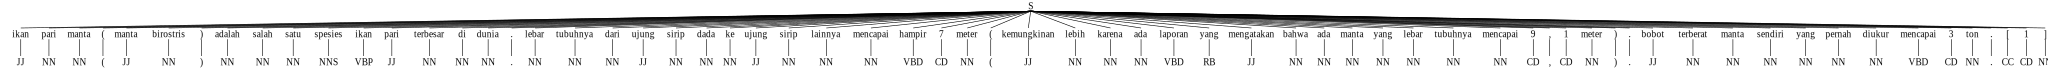

In [78]:
entities = nltk.chunk.ne_chunk(tagged)
entities